In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn import cluster
import os
import re
# import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
os.getcwd()


'c:\\Users\\dscshap3808\\Documents\\my_scripts_new\\play1'

In [2]:
df = pd.read_csv('./daily_ou_kpi.csv') 
re1 = re.compile(r'(?<=\.).+')
df.columns = [re1.findall(i)[0] for i in list(df.columns.to_numpy())]
# df.to_csv('./daily_kpi_all_810.csv', encoding='utf_8_sig')
 
df['operation_day'].apply(str).apply(int).min()

20210406

In [3]:
clean_df1 = (df.groupby('ou_code')['operation_day'].count() <2).reset_index()
clean_df1.columns = ['ou_code', 'flag1']
df = clean_df1.merge(df, on = 'ou_code', how = 'inner')
df = df[df['flag1'] == False]

clean_df2 = df.groupby('ou_code')[[
    'inbound_receive_qty', 'outbound_shipped_qty'
    ]].sum().reset_index()
clean_df2['sum'] = clean_df2.sum(axis = 1)
clean_df2 = clean_df2[clean_df2['sum'] != 0]
df = df[df['ou_code'].isin(clean_df2.ou_code)]

clean_df3 = (df.groupby('ou_code')[[
    'total_working_hour'
    ]].sum() == 0).reset_index()
clean_df3 = clean_df3[clean_df3['total_working_hour'] == False]
# clean_df4 = (df.groupby('ou_code')[[
#     'outsource_working_hour'
#     ]].sum() == 0).reset_index()
# clean_df4 = clean_df4[clean_df4['outsource_working_hour'] == False]
# df = df[df['ou_code'].isin(clean_df4.ou_code)]
# df= df.reset_index()
 
# df = df[df['ou_code'].isin(clean_df3.ou_code)]
# df= df.reset_index()

df = df[[
    'ou_code','operation_day', 'inbound_receive_qty', 'is_holiday',
    'outbound_shipped_qty','total_head_count','total_working_hour',
    'outsource_working_hour', 'perm_working_hour',
    'other_working_hour', 'direct_working_hour', 'indirect_working_hour',
    'outbound_inbound_qty_ratio', 'perm_working_hour_ratio',
    'working_hour_per_head', 'location_usage_rate', 'location_idle_rate']]
df = df.fillna(0)
df = df[df['total_working_hour'] != 0]
df.head()

,ou_code,operation_day,inbound_receive_qty,is_holiday,outbound_shipped_qty,total_head_count,total_working_hour,outsource_working_hour,perm_working_hour,other_working_hour,direct_working_hour,indirect_working_hour,outbound_inbound_qty_ratio,perm_working_hour_ratio,working_hour_per_head,location_usage_rate,location_idle_rate
0,CN-001,20210430,0.0,0,1699.0,4.0,32.75,0.0,0.00,0.0,32.75,0.0,0.000000,0.0,8.1875,0.000000,0.000000
1,CN-001,20210619,0.0,1,0.0,3.0,30.00,0.0,30.00,0.0,30.00,0.0,0.000000,1.0,10.0000,0.011628,0.988372
2,CN-001,20210427,4794.0,0,7392.0,4.0,32.28,0.0,0.00,0.0,32.28,0.0,1.541927,0.0,8.0700,0.000000,0.000000
3,CN-001,20210419,11400.0,0,6000.0,4.0,33.25,0.0,0.00,0.0,33.25,0.0,0.526316,0.0,8.3125,0.000000,0.000000
4,CN-001,20210617,114.0,0,13527.0,5.0,40.58,0.0,40.58,0.0,40.58,0.0,118.657895,1.0,8.1160,0.001600,0.998400


In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
res = smf.ols(
    'total_working_hour ~ inbound_receive_qty + outbound_shipped_qty', 
    data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     total_working_hour   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     894.6
Date:                Wed, 22 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:44:14   Log-Likelihood:                -56357.
No. Observations:                8484   AIC:                         1.127e+05
Df Residuals:                    8481   BIC:                         1.127e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              154.2519      2.040     75.615      0.000     150.253     158.251
inbound_receive_qty    7.17e-07    9.4e-08      7.630      0.000    5.33e-07    9.01e-07
outbound_shipped_qty  2.579e-06   1.08e-07     23.877      0.000    2.37e-06    2.79e-06
==============================================================================
Omnibus:                     2975.559   Durbin-Watson:                   0.385
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10085.501
Skew:                           1.788   Prob(JB):                         0.00
Kurtosis:                       6.968   Cond. No.                     3.83e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.83e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [5]:
df['operation_day'] = pd.to_datetime(df['operation_day'].apply(str), yearfirst = True)
df.set_index(['ou_code', 'operation_day'], inplace=True)
from linearmodels import PanelOLS
# Regression
FE = PanelOLS(df['total_working_hour'], df[['inbound_receive_qty','outbound_shipped_qty']],
            entity_effects = True,
            time_effects = True,
            check_rank =True,
              )
            
# Result
result = FE.fit(
  cov_type = 'clustered',\
  cluster_entity=True,
  cluster_time=True
            )
result

Dep. Variable:,total_working_hour,R-squared:,0.1325
Estimator:,PanelOLS,R-squared (Between):,0.0982
No. Observations:,8484,R-squared (Within):,0.1257
Date:,"Wed, Sep 22 2021",R-squared (Overall):,0.1009
Time:,16:44:16,Log-likelihood,-4.744e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,631.10
Entities:,65,P-value,0.0000
Avg Obs:,130.52,Distribution:,"F(2,8267)"
Min Obs:,49.000,,
Max Obs:,151.00,F-statistic (robust):,75.479


In [6]:
df['ou_codes'] = df.index.get_level_values(0)  

# dkrei predicitoonS

In [7]:
from mlxtend.regressor import StackingRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [9]:
data_all = df.copy();data_all.head(6)

inbound_receive_qty  is_holiday  outbound_shipped_qty  \
ou_code operation_day                                                          
CN-001  2021-04-30                     0.0           0                1699.0   
        2021-06-19                     0.0           1                   0.0   
        2021-04-27                  4794.0           0                7392.0   
        2021-04-19                 11400.0           0                6000.0   
        2021-06-17                   114.0           0               13527.0   
        2021-04-15                 17922.0           0                1591.0   

                       total_head_count  total_working_hour  \
ou_code operation_day                                         
CN-001  2021-04-30                  4.0               32.75   
        2021-06-19                  3.0               30.00   
        2021-04-27                  4.0               32.28   
        2021-04-19                  4.0               33.25   
        2021-06-17                  5.0               40.58   
        2021-04-15                  4.0               34.75   

                       outsource_working_hour  perm_working_hour  \
ou_code operation_day                                              
CN-001  2021-04-30                        0.0               0.00   
        2021-06-19                        0.0              30.00   
        2021-04-27                        0.0               0.00   
        2021-04-19                        0.0               0.00   
        2021-06-17                        0.0              40.58   
        2021-04-15                        0.0               0.00   

                       other_working_hour  direct_working_hour  \
ou_code operation_day                                            
CN-001  2021-04-30                    0.0                32.75   
        2021-06-19                    0.0                30.00   
        2021-04-27                    0.0                32.28   
        2021-04-19                    0.0                33.25   
        2021-06-17                    0.0                40.58   
        2021-04-15                    0.0                34.75   

                       indirect_working_hour  outbound_inbound_qty_ratio  \
ou_code operation_day                                                      
CN-001  2021-04-30                       0.0                    0.000000   
        2021-06-19                       0.0                    0.000000   
        2021-04-27                       0.0                    1.541927   
        2021-04-19                       0.0                    0.526316   
        2021-06-17                       0.0                  118.657895   
        2021-04-15                       0.0                    0.088774   

                       perm_working_hour_ratio  working_hour_per_head  \
ou_code operation_day                                                   
CN-001  2021-04-30                         0.0                 8.1875   
        2021-06-19                         1.0                10.0000   
        2021-04-27                         0.0                 8.0700   
        2021-04-19                         0.0                 8.3125   
        2021-06-17                         1.0                 8.1160   
        2021-04-15                         0.0                 8.6875   

                       location_usage_rate  location_idle_rate ou_codes  
ou_code operation_day                                                    
CN-001  2021-04-30                0.000000            0.000000   CN-001  
        2021-06-19                0.011628            0.988372   CN-001  
        2021-04-27                0.000000            0.000000   CN-001  
        2021-04-19                0.000000            0.000000   CN-001  
        2021-06-17                0.001600            0.998400   CN-001  
        2021-04-15                0.000000            0.000000   CN-001

In [10]:
from sklearn.model_selection import train_test_split  
train, test  = train_test_split(data_all, \
    test_size=0.20, random_state=42, stratify = data_all['ou_codes'])
train, valid = train_test_split(train, \
    test_size=0.20, random_state=42, stratify = train['ou_codes'])

In [11]:
def go_dummie(df):
    df = pd.concat([df.drop('ou_codes', axis =1) , pd.get_dummies(df['ou_codes'])], axis =1)
    return df
train, valid, test = [go_dummie(i) for i in [train, valid, test]]


In [12]:
train_y = train.pop('total_working_hour')
valid_y = valid.pop('total_working_hour')

In [13]:
import time #implementing in this function the time spent on training the model
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

def modelfit(alg, dtrain, target, only_predict = False):
    #Fit the algorithm on the data
    time_start = time.perf_counter() #start counting the time
    if not only_predict:
        alg.fit(dtrain, target)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    
    kfolds = KFold(n_splits=6, shuffle=True, random_state=42)
    
    cv_score = cross_val_score(alg, dtrain,target, cv=kfolds, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(-cv_score)
    
    time_end = time.perf_counter()
    
    total_time = time_end-time_start
    #Print model report:
    print("\nModel Report")
    print("RMSE :  {:.4f}".format(np.sqrt(mean_squared_error(target, dtrain_predictions))))
    print("CV Score : Mean -  %.4f | Std -  %.4f | Min -  %.4f | Max - %.4f" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    print("Amount of time spent during training the model and cross validation: %4.3f seconds" % (total_time))
    
def plot_feature_importance(model, df):
    feature_importance = model.feature_importances_[:30]
    # make importances relative to max importance
    plt.figure(figsize=(20, 20)) #figure size
    feature_importance = 100.0 * (feature_importance / feature_importance.max()) #making it a percentage relative to the max value
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, df.columns[sorted_idx], fontsize=15) #used train_drop here to show the name of each feature instead of our train_prepared 
    plt.xlabel('Relative Importance', fontsize=20)
    plt.ylabel('Features', fontsize=20)
    plt.title('Variable Importance', fontsize=30)

,,inbound_receive_qty,is_holiday,outbound_shipped_qty,total_head_count,outsource_working_hour,perm_working_hour,other_working_hour,direct_working_hour,indirect_working_hour,outbound_inbound_qty_ratio,...,HK-008,HK-015,HK-027,HK-038,HK-043,HK-047,HK-050,HK-051,HK-052,HK-115
ou_code,operation_day,,,,,,,,,,,,,,,,,,,,,
CN-067,2021-07-11,114320.0,1,86497.0,23.0,188.00,76.38,0.0,240.33,24.05,0.756622,...,0,0,0,0,0,0,0,0,0,0
CN-110,2021-06-11,538.0,0,3629.0,2.0,19.79,0.00,0.0,19.79,0.00,6.745353,...,0,0,0,0,0,0,0,0,0,0
CN-258,2021-06-29,0.0,0,0.0,18.0,74.00,82.71,0.0,147.68,9.03,0.000000,...,0,0,0,0,0,0,0,0,0,0
CN-239,2021-05-08,0.0,0,418713.0,4.0,0.00,0.00,0.0,32.15,0.00,0.000000,...,0,0,0,0,0,0,0,0,0,0
CN-209,2021-06-23,342518.0,0,503572.0,16.0,66.50,117.58,0.0,175.33,8.75,1.470206,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CN-031,2021-06-08,1184.0,0,279.0,1.0,0.00,8.02,0.0,8.02,0.00,0.235642,...,0,0,0,0,0,0,0,0,0,0
CN-403,2021-06-05,173080905.0,1,2608863.0,56.0,0.00,0.00,0.0,544.26,9.77,0.015073,...,0,0,0,0,0,0,0,0,0,0
CN-242,2021-08-31,0.0,0,0.0,2.0,0.00,17.00,0.0,7.75,9.25,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [23]:
lin_reg = LinearRegression()
modelfit(lin_reg, train, train_y)


Model Report
RMSE :  0.0000
CV Score : Mean -  0.0000 | Std -  0.0000 | Min -  0.0000 | Max - 0.0000
Amount of time spent during training the model and cross validation: 0.268 seconds


In [39]:
from sklearn.linear_model import Lasso
rid_reg = Lasso()
modelfit(rid_reg, train, train_y)


Model Report
RMSE :  0.0181
CV Score : Mean -  0.0178 | Std -  0.0024 | Min -  0.0146 | Max - 0.0206
Amount of time spent during training the model and cross validation: 1.388 seconds


In [15]:
%%time
forest_reg = RandomForestRegressor(n_estimators=300, 
                                   random_state=1026, 
                                   min_samples_leaf=5,
                                   min_samples_split = 5,
                                   max_depth = 15,
                                   n_jobs=-1, oob_score=True)
modelfit(forest_reg, train, train_y)


Model Report
RMSE :  4.6620
CV Score : Mean -  6.1535 | Std -  1.9010 | Min -  4.3007 | Max - 10.0638
Amount of time spent during training the model and cross validation: 61.108 seconds
Wall time: 1min 1s


In [18]:
# plot_feature_importance(forest_reg, train)


In [20]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=421, max_depth = 15, min_samples_split = 5)
modelfit(tree_reg, train, train_y) 


Model Report
RMSE :  1.4918
CV Score : Mean -  6.0832 | Std -  1.2517 | Min -  4.7777 | Max - 8.0901
Amount of time spent during training the model and cross validation: 0.730 seconds


In [21]:
from sklearn.ensemble import AdaBoostRegressor

# tree_ada = DecisionTreeRegressor(random_state = 42,max_depth = 4)

ada_reg = AdaBoostRegressor(
    tree_reg, n_estimators=300, random_state=42,learning_rate=0.009, loss='square')
modelfit(ada_reg, train, train_y)

# 181.589


Model Report
RMSE :  0.2867
CV Score : Mean -  3.8149 | Std -  0.5868 | Min -  3.0120 | Max - 4.6985
Amount of time spent during training the model and cross validation: 220.089 seconds


In [22]:
params = {'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}

params_1 = {'n_estimators': 1000, 'learning_rate': 0.05, 'max_depth' : 14,
            'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 5, 
            'loss': 'huber', 'random_state': 42}

# train_dummies_prepared = num_pipeline.fit_transform(train_dummies)

gdb_model = GradientBoostingRegressor(**params_1)
modelfit(gdb_model, train, train_y)


Model Report
RMSE :  6.3090
CV Score : Mean -  12.8319 | Std -  2.8306 | Min -  9.8100 | Max - 16.9810
Amount of time spent during training the model and cross validation: 385.655 seconds


In [52]:
from mlxtend.regressor import StackingRegressor

stck_reg = StackingRegressor(
    [forest_reg, tree_reg, ada_reg], 
    meta_regressor = ada_reg, 
     verbose=1)

stck_reg.fit(train, train_y)

Fitting 3 regressors...
Fitting regressor1: randomforestregressor (1/3)
Fitting regressor2: decisiontreeregressor (2/3)
Fitting regressor3: adaboostregressor (3/3)


StackingRegressor(meta_regressor=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=15,
                                                                                        min_samples_split=5,
                                                                                        random_state=421),
                                                   learning_rate=0.009,
                                                   loss='square',
                                                   n_estimators=300,
                                                   random_state=42),
                  regressors=[RandomForestRegressor(max_depth=15,
                                                    min_samples_leaf=5,
                                                    min_samples_split=5,
                                                    n_estimators=300, n_jobs=-1,
                                                    oob_score=True,
                                              

In [53]:

target = stck_reg.predict(valid)

np.sqrt(mean_squared_error(target, valid_y))

3.72873217522552

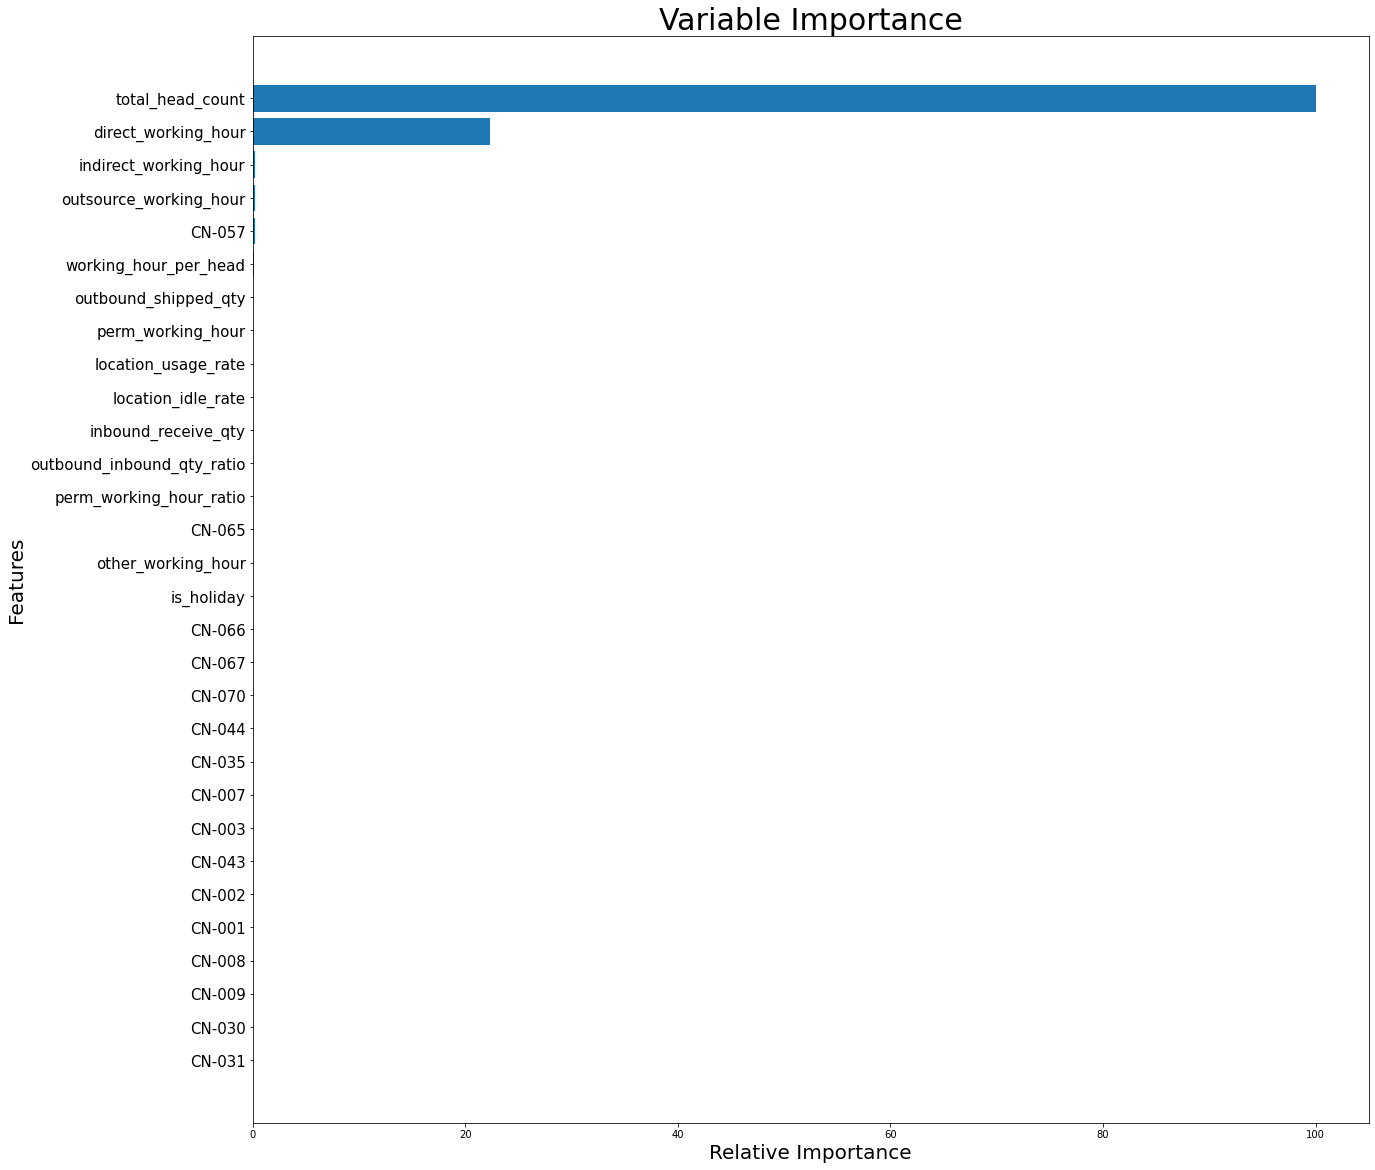

In [56]:
plot_feature_importance(ada_reg, train)

In [48]:

target = ada_reg.predict(valid)

np.sqrt(mean_squared_error(target, valid_y))

3.6788295181109434

In [51]:

target = forest_reg.predict(valid)

np.sqrt(mean_squared_error(target, valid_y))

6.251478370175772